# Word embeddings in spaCy

The previous [section](embeddings.ipynb) introduced the concept of word embeddings using a toy example with just a few sentences.

This section focuses on word embeddings learned from massive volumes of text and how to use them in spaCy.

After reading this section, you should:

 - understand what word embeddings can be used for
 - know how to use word embeddings in spaCy
 - know how to visualise words in their embedding space
 - know how to use contextual word embeddings in spaCy
 - know how to add a custom component to the spaCy pipeline

## Using word embeddings in spaCy

spaCy provides 300-dimensional word embeddings for several languages, which have been learned from large corpora.

In other words, each word in the model's vocabulary is represented by a list of 300 floating point numbers – a vector – and these vectors are embedded into a 300-dimensional space.

To explore the use of word vectors in spaCy, let's start by loading a large language model for English, which contains word vectors for 685 000 *Tokens*.

In [1]:
# Import spacy
import spacy

# Load a large language model and assign it to the variable 'nlp'
nlp = spacy.load('en_core_web_lg')

Let's define an example sentence and feed it to the language model under `nlp` for processing.

In [2]:
# Define example sentence
text = "The Shiba Inu is a dog that is more like a cat."

# Feed example sentence to the language model
doc = nlp(text)

# Call the variable to examine the output
doc

The Shiba Inu is a dog that is more like a cat.

Let's examine the word vector for the second *Token* in the *Doc* object ("Shiba"), which can be accessed through the *Token* attribute `vector`.

Instead of printing the 300 floating point numbers that constitute the vector, let's limit the output to the first thirty dimensions using `[:30]`.

In [3]:
# Retrieve the second Token in the Doc object, and the first
# 30 dimensions of its vector representation
doc[1].vector[:30]

array([ 0.17141 ,  0.23299 ,  0.40017 , -0.58668 ,  0.051284, -0.047777,
       -0.10999 , -0.081705, -0.12037 , -1.1385  ,  0.075536, -0.32489 ,
       -0.97602 , -0.24535 , -0.15917 ,  0.95671 ,  0.44824 , -0.72333 ,
        0.038381, -0.2252  , -0.25301 ,  0.12206 ,  0.14714 , -0.50761 ,
       -0.1471  ,  0.4988  , -0.21991 , -0.51972 , -0.030737, -0.041938],
      dtype=float32)

These floating point numbers encode information that the model has learned for the *Token*, based on the linguistic context in which the *Token* occurs.

Just as in the [previous section](embeddings.ipynb), we can use [cosine similarity](https://en.wikipedia.org/wiki/Cosine_similarity) to measure the similarity of two vectors. 

spaCy implements cosine similarity in the `similarity()` method, which is included for *Tokens*, *Spans* and *Docs*.

The `similarity()` method can take any of these objects as input and calculate cosine similarity between the objects.

For convenience, let's assign the *Tokens* 'dog' and 'cat' in our example *Doc* object into the variables `dog` and `cat` and compare their similarity.

In [4]:
# Assing the fifth and eleventh items in the Doc into their own variables
dog = doc[5]
cat = doc[11]

# Compare the similarity between Tokens 'dog' and 'cat'
dog.similarity(cat)

0.80168545

Not surprisingly, the vectors for cats and dogs are very similar, because these words are likely to appear in similar linguistic contexts, as both cats and dogs are common household pets.

For comparison, let's retrieve the vector representation for a snake.

In [5]:
# Feed the string "snake" to the language model; store result under 'snake'
snake = nlp("snake")

# Compare the similarity of 'snake' and 'dog'
snake.similarity(dog)

0.3942871574504599

Turns out the vector for snake is not that similar to the vector for dog.

Finally, let's compare the similarity of the vectors for car and snake.

In [6]:
snake.similarity(nlp("car"))

0.19543902497718393

Not surprisingly, the vectors for car and snake are not very similar at all, as these words are not likely to occur in similar linguistic contexts.

### Quick exercise

Define two words with similar or dissimilar meanings, feed them to the language model and compare their cosine similarity.

In [7]:
# Write your code below this line and press Shift and Enter to run the code


*spaCy* also provides word vectors for entire *Doc* objects or *Span* objects within them.

To move beyond *Tokens*, let's start by examining the *Doc* object. 

In [8]:
# Call the variable to examine the output
doc

The Shiba Inu is a dog that is more like a cat.

The vector for this *Doc* object is also available under the attribute `vector`.

Instead of examining the actual vector stored under `vector`, let's retrieve its `shape` attribute.

In [9]:
# Retrieve the 'shape' attribute for the vector
doc.vector.shape

(300,)

Just like the *Token* objects above, the *Doc* object has a 300-dimensional vector.

The vector representation for the entire *Doc* is calculated by **averaging the vectors** for each *Token* in the *Doc*.

The same applies to _Spans_, which can be examined by retrieving the noun phrases in `doc`, which are available under the `noun_chunks` attribute.

In [10]:
# Get the noun chunks under the attribute 'noun_chunks'. This returns
# a generator, so we cast the output into a list named 'n_chunks'.
n_chunks = list(doc.noun_chunks)

# Call the variable to examine the output
n_chunks

[The Shiba Inu, a dog, a cat]

The example sentence has three noun phrases. 

Let's examine the shape of the vector for the first noun phrase, "The Shiba Inu".

In [11]:
# Get the shape of the vector for the first noun chunk in the list
n_chunks[0].vector.shape

(300,)

Just as the *Doc* object, the *Span* object has a 300-dimensional vector. This vector is also calculated by averaging the vectors for each *Token* in the *Span*.

We can also use the `similarity()` method to measure cosine similarity between Spans.

Let's compare the similarity of noun phrases "The Shiba Inu" `[0]` and "a dog" `[1]`.

Based on our world knowledge, we should know that both noun phrases belong to the same semantic field: as a dog breed, the Shiba Inu is a hyponym of dog. For this reason, they should presumably occur in similar contexts and thus their vectors should be close to each other in the embedding space.

In [12]:
# Compare the similarity of the two noun chunks
n_chunks[0].similarity(n_chunks[1])

0.39694768

Turns out that the embeddings for the noun phrases "The Shiba Inu" and "a dog" are about as similar as those of a dog and a snake above!

To understand why the vectors for these noun phrases are dissimilar, we must delve deeper into the word embeddings and the effects of averaging vectors for linguistic units that are larger than a single *Token*.

## Visualising word embeddings

whatlies is an open source library for visualising "what lies" in word embeddings, that is, what kinds of information they encode (Warmerdam et al. [2020](https://www.aclweb.org/anthology/2020.nlposs-1.8.pdf)).

The whatlies library is intended to support the interpretation of high-dimensional word embeddings. In this context, high-dimensional refers to the number of dimensions in the embedding space.

High-dimensional spaces are notoriously difficult to comprehend, as our experience as embodied beings is strongly grounded into a three-dimensional space complemented by the dimension of time.

Visualisations such as those provided by whatlies may help to alleviate this challenge.

In [13]:
# Import the whatlies library
import whatlies

whatlies provides wrappers for language models from various popular natural language processing libraries, including spaCy.

These wrappers are essentially Python classes that know what to do with a language model from a given Python library.

We therefore import the `SpacyLanguage` object from whatlies and *wrap* the spaCy language model stored under the `nlp` variable into this object. 

We then assign the result to the variable `language_model`. 

In [14]:
# Import the wrapper class for spaCy language models
from whatlies.language import SpacyLanguage

# Wrap the spaCy language model under 'nlp' into the
# whatlies SpacyLanguage class and assign the result 
# under the variable 'language_model'
language_model = SpacyLanguage(nlp)

# Call the variable to examine the output
language_model

SpacyLanguage(nlp=<spacy.lang.en.English object at 0x10a91a250>)

The result is a *SpacyLanguage* object that wraps a spaCy language model named `nlp`.

Let's continue by taking a closer look at the list of noun phrases stored under `n_chunks`.

In [15]:
# Loop over each noun phrase
for chunk in n_chunks:
    
    # Loop over each Token in noun phrase
    for token in chunk:
        
        # Print Token attributes 'text', 'oov', 'vector' and separate
        # each attribute by a string object containing a tabulator \t
        # sequence for pretty output
        print(token.text, '\t', token.is_oov, '\t', token.vector[:3])

The 	 False 	 [ 0.27204 -0.06203 -0.1884 ]
Shiba 	 False 	 [0.17141 0.23299 0.40017]
Inu 	 False 	 [-0.00083872 -0.12982     0.29831   ]
a 	 False 	 [ 0.043798  0.024779 -0.20937 ]
dog 	 False 	 [-0.40176   0.37057   0.021281]
a 	 False 	 [ 0.043798  0.024779 -0.20937 ]
cat 	 False 	 [-0.15067  -0.024468 -0.23368 ]


The `is_oov` attribute of a *Token* corresponds to *out of vocabulary* and returns `True` or `False` depending on whether the *Token* is included in the vocabulary of the language model or not.

In this case, all *Tokens* are present in the vocabulary, hence their value is `False`.

`vector[:3]` returns the first three dimensions in the 300-dimensional word vector.

If a *Token* were out of vocabulary, the values of each dimension would be set to zero.

Let's examine this by mistyping "Shiba Inu" as "shibainu", feed this string to the language model under `nlp` and retrieve the values for the first three dimensions of its vector.

In [16]:
# Feed the string 'shibainu' to the language model and assign
# the result under the variable 'shibainu'
shibainu = nlp("shibainu")

# Retrieve the first three dimensions of its word vector
shibainu.vector[:3]

array([0., 0., 0.], dtype=float32)

The first three dimensions are set to zero, suggesting that the word is out of vocabulary.

We can easily double-check this using the `is_oov` attribute.

In [17]:
shibainu[0].is_oov

True

This is important, because the values of each dimension determine the *direction* and *magnitude* of the vector in the embedding space.

Zero values provide no information about the direction and magnitude of the vector.

We can use the visualisations in whatlies to explore this idea further.

To examine the embeddings for noun phrases in the `n_chunks` list using whatlies, we must populate the list with string objects rather than *Spans*.

We therefore define a list comprehension that retrieves the plain text stored under the attribute `text` of a *Span* object and stores this string into a list of the same name, that is, `n_chunks`.

In [18]:
# Loop over noun chunks, retrieve plain text and store
# the result under the variable 'n_chunks'
n_chunks = [n_chunk.text for n_chunk in n_chunks]

# Call the variable to examine the output
n_chunks

['The Shiba Inu', 'a dog', 'a cat']

Now that we have the noun chunks in a list, we can feed them to the *SpacyLanguage* object stored under `language_model`.

The input must be placed in brackets `[ ]` right after the variable name.

In [19]:
# Retrieve embeddings for items in list 'n_chunks'
# and store the result under 'embeddings'
embeddings = language_model[n_chunks]

# Call the variable to examine the output
embeddings

EmbSet

This returns an *EmbSet* object which stores the embeddings for our noun phrases.

To visualize the embeddings, we can use the `plot()` method of the *EmbSet* object.

The arguments `kind`, `color`, `x_axis` and `y_axis` instruct *whatlies* to draw red arrows that plot the direction and magnitude of each vector along dimensions 1 and 2.

EmbSet

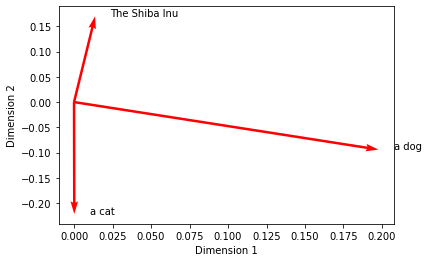

In [20]:
embeddings.plot(kind='arrow', color='red', x_axis=1, y_axis=2)

Each vector originates at the point $(0, 0)$. We can see that along dimensions 1 and 2, the directions and magnitudes of the vectors differ considerably.

This results from averaging the vectors for each *Token* in the noun phrase.

To understand the effects of averaging vectors, let's retrieve embeddings for the indefinite article "a", the noun "dog" and the noun phrase "a dog" and plot the result along the same dimensions as above.

EmbSet

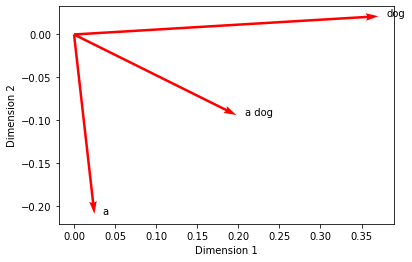

In [21]:
language_model[['a', 'dog', 'a dog']].plot(kind='arrow', color='red', x_axis=1, y_axis=2)

The vector for "a dog" is positioned right in the middle between the vectors for "a" and "dog", because the vector for "a dog" is an average of the vectors for "a" and "dog".

This raises the question whether averaging vectors for individual *Tokens* is suitable for representing linguistic units beyond single words, because the direction and magnitude of a vector are supposed to represent the "meaning" of a word in relation to those of other words in the model vocabulary.

Averaging *Token* vectors for representing clauses and sentences may dilute the information encoded in the vectors. Another issue emerges from the relative weight of the averaged weights: whether the indefinite article "a" and the noun "dog" are equally important is questionable.

Here the problem is that word embeddings are used to learn representations for a *single Token* based on their linguistic context of occurrence, but the resulting representations **do not** encode any information about the context in which the *Token* appears.

Put differently, word embeddings leverage information about linguistic context during learning, but this information is not encoded into the word embeddings themselves.

This limitation has been addressed in the [Transformer](https://en.wikipedia.org/wiki/Transformer_(machine_learning_model)), an alternative architecture for learning representations for words.

Some models that build on this architecture include BERT (Devlin et al. [2019](https://www.aclweb.org/anthology/N19-1423/)) and GPT-3 (Brown et al. [2020](https://papers.nips.cc/paper/2020/hash/1457c0d6bfcb4967418bfb8ac142f64a-Abstract.html)). Both models are massive, featuring billions of parameters that encode information about words *and* the contexts in which they occur.

## Contextual embeddings from Transformers

One core idea behind Transformers is to learn a language model from massive amounts of data and to adapt what the model has learned to more specific tasks. Put differently, the idea is to transfer what the model has learned to other tasks.

spaCy provides Transformer-based language models for English and several other languages, which outperform the "traditional" pipelines in terms of accuracy.

Let's start by loading a Transformer-based for the English language.

In [22]:
# Load a Transformer-based language model; assing to variable 'nlp'
nlp = spacy.load('en_core_web_trf')

On the surface, a *Language* object that contains a Transformer-based model looks and works just like any other language model in spaCy.

However, if we look under the hood of the *Language* object using the `pipeline` attribute, we will see that the first component in the processing pipeline is a *Transformer*.

In [23]:
# Call the 'pipeline' attribute to examine the processing pipeline
nlp.pipeline

[('transformer',
  <spacy_transformers.pipeline_component.Transformer at 0x19f5edc70>),
 ('tagger', <spacy.pipeline.tagger.Tagger at 0x19f5fe770>),
 ('parser', <spacy.pipeline.dep_parser.DependencyParser at 0x19f5d31c0>),
 ('ner', <spacy.pipeline.ner.EntityRecognizer at 0x19f5d32e0>),
 ('attribute_ruler',
  <spacy.pipeline.attributeruler.AttributeRuler at 0x19f61e6c0>),
 ('lemmatizer', <spacy.lang.en.lemmatizer.EnglishLemmatizer at 0x19f619480>)]

The Transformer component generates vector representations that are then used for making predictions about the *Doc* and the *Tokens* contained within.

These include, among others, the standard linguistic annotations in the form of part-of-speech tags, syntactic dependencies, named entities and lemmas.

Let's define an example sentence and feed it to the Transformer-based language model.

In [24]:
# Feed an example sentence to the model; store output under 'example_doc'
example_doc = nlp("Helsinki is the capital of Finland.")

# Check the length of the Doc object
example_doc.__len__()

7

spaCy stores the vector representations generated by the Transformer into a *TransformerData* object, which can be accessed under the custom attribute `trf_data` of a *Doc* object.

Remember that spaCy stores custom attributes under a dummy attribute marked by an underscore `_`, which is reserved for user-defined attributes.

In [25]:
# Check the type of the 'trf_data' object
type(example_doc._.trf_data)

spacy_transformers.data_classes.TransformerData

The output of the Transformer is contained in the *TransformerData* object.

To begin with, the `tensors` attribute contains a list with vector representations generated by the Transformer for both *Tokens* and the entire *Doc*.

The first item in the `tensors` list contains the output for individual *Tokens*, whereas the second item holds the output for the entire *Doc*.

In [26]:
# Check the shape of the first tensor in the list
example_doc._.trf_data.tensors[0].shape

(1, 11, 768)

The Transformer output is stored in a *tensor*, which is a mathematical term for describing a bundle of numerical objects and their shape. In this case, we have a batch of 1 that consists of 11 vectors with 768 dimensions each.

We can access the first ten dimensions of each vector using the expression `[:10]`. Note that we need the preceding expression `[0]` to enter the first "batch" of vectors in the tensor.

In [27]:
# Check the first ten dimensions of the tensor
example_doc._.trf_data.tensors[0][0][:10]

array([[-0.38942632, -0.24962673, -0.8063266 , ...,  0.81720364,
         0.72307056, -0.04623879],
       [ 0.31577387, -0.5261144 , -0.45403042, ...,  1.3939978 ,
         0.11791697,  0.5760454 ],
       [ 0.32838398, -0.36977422, -0.5587727 , ...,  1.5188134 ,
        -0.01872119,  0.55528253],
       ...,
       [-1.3185265 , -0.780314  ,  0.44595063, ...,  0.0667331 ,
         1.4564198 , -0.22971925],
       [-0.9221598 , -0.11298705, -0.3108006 , ...,  1.3190664 ,
        -0.18129694,  0.1107993 ],
       [-0.5790503 , -0.15829325, -1.2781848 , ...,  1.1679012 ,
         0.88122773, -0.14454758]], dtype=float32)

Unlike word embeddings, which leverage contextual information to *learn* representations for tokens, these embeddings also encode information about the context of occurrence into the representation!

But why is a *Doc* with 7 *Tokens* represented by 11 vectors?

In the [previous section](embeddings.ipynb) we learned that model size grows together with vocabulary. Because Transformers are trained on massive volumes of text, the size of the model's vocabulary must be limited.

Instead of learning a mapping between individual words and vectors, Transformers use advanced tokenizers that identify frequently occurring character sequences in the data and learn embeddings for these sequences instead.

Let's examine how the example *Doc* under `example_doc` was tokenized for the Transformer.

This information is stored under the `input_texts` key under the `tokens` attribute.

In [28]:
example_doc._.trf_data.tokens['input_texts']

[['<s>',
  'H',
  'els',
  'inki',
  'Ġis',
  'Ġthe',
  'Ġcapital',
  'Ġof',
  'ĠFinland',
  '.',
  '</s>']]

This lists the tokens provided to the Transformer *by its own tokenizer*. In other words, the Transformer does not use the same tokens as spaCy.

The input begins and terminates with tokens `<s>` and `</s>`, which mark the beginning and the end of the input sequence. The Transformer tokenizer also uses the character `Ġ` as a prefix to indicate that the token is preceded by a whitespace character.

For the most part, the Transformer tokens correspond roughly to those produced by spaCy, except for "Helsinki".

Because the token "Helsinki" is not present in the Transformer's vocabulary, the token is broken down into three character sequences that exist in the vocabulary: `H`, `els` and `inki`. Their vectors are used to construct a representation for the token "Helsinki".

To map these vectors to *Tokens* in the spaCy *Doc* object, we must retrieve alignment information from the `align` attribute of the *TransformerData* object.

The `align` attribute can be indexed using *Token* indices of the *Doc* object. To exemplify, we can retrieve the first *Token* "Helsinki" in the *Doc* object `doc` using the expression `example_doc[0]`.

We then use this index to retrieve alignment data from a *Ragged* object, which is stored under the `align` attribute. More specifically, we need the information stored under its attribute `data`.

In [29]:
# Get the first spaCy Token, "Helsinki", and its alignment data
example_doc[0], example_doc._.trf_data.align[0].data

(Helsinki,
 array([[1],
        [2],
        [3]], dtype=int32))

The `data` attribute contains a NumPy array that identifies which tensors under `tensors` contain representations for this *Token*. In this case, vectors 1, 2 and 3 in the batch of 11 vectors contain the representation for "Helsinki".

To use the contextual embeddings from the Transformer efficiently, we can define a component that retrieves contextual embeddings for *Docs*, *Spans* and *Tokens* and add this component to the spaCy pipeline.

This can be achieved by creating a new Python *Class* – a user-defined object with attributes and methods.

Because the new *Class* will become a component of the spaCy pipeline, we must first import the *Language* object and let spaCy know that we are now defining a new pipeline component.

In [30]:
# Import the Language object under the 'language' module in spaCy,
# and NumPy for calculating cosine similarity.
from spacy.language import Language
import numpy as np

# We use the @ character to register the following Class definition
# with spaCy under the name 'tensor2attr'.
@Language.factory('tensor2attr')

# We begin by declaring the class name: Tensor2Attr. The name is 
# declared using 'class', followed by the name and a colon.
class Tensor2Attr:
    
    # We continue by defining the first method of the class, 
    # __init__(), which is called when this class is used for 
    # creating a Python object. Custom components in spaCy 
    # require passing two variables to the __init__() method:
    # 'name' and 'nlp'. The variable 'self' refers to any
    # object created using this class!
    def __init__(self, name, nlp):
        
        # We do not really do anything with this class, so we
        # simply move on using 'pass' when the object is created.
        pass

    # The __call__() method is called whenever some other object
    # is passed to an object representing this class. Since we know
    # that the class is a part of the spaCy pipeline, we already know
    # that it will receive Doc objects from the preceding layers.
    # We use the variable 'doc' to refer to any object received.
    def __call__(self, doc):
        
        # When an object is received, the class will instantly pass
        # the object forward to the 'add_attributes' method. The
        # reference to self informs Python that the method belongs
        # to this class.
        self.add_attributes(doc)
        
        # After the 'add_attributes' method finishes, the __call__
        # method returns the object.
        return doc
    
    # Next, we define the 'add_attributes' method that will modify
    # the incoming Doc object by calling a series of methods.
    def add_attributes(self, doc):
        
        # spaCy Doc objects have an attribute named 'user_hooks',
        # which allows customising the default attributes of a 
        # Doc object, such as 'vector'. We use the 'user_hooks'
        # attribute to replace the attribute 'vector' with the 
        # Transformer output, which is retrieved using the 
        # 'doc_tensor' method defined below.
        doc.user_hooks['vector'] = self.doc_tensor
        
        # We then perform the same for both Spans and Tokens that
        # are contained within the Doc object.
        doc.user_span_hooks['vector'] = self.span_tensor
        doc.user_token_hooks['vector'] = self.token_tensor
        
        # We also replace the 'similarity' method, because the 
        # default 'similarity' method looks at the default 'vector'
        # attribute, which is empty! We must first replace the
        # vectors using the 'user_hooks' attribute.
        doc.user_hooks['similarity'] = self.get_similarity
        doc.user_span_hooks['similarity'] = self.get_similarity
        doc.user_token_hooks['similarity'] = self.get_similarity
    
    # Define a method that takes a Doc object as input and returns 
    # Transformer output for the entire Doc.
    def doc_tensor(self, doc):
        
        # Return Transformer output for the entire Doc. As noted
        # above, this is the last item under the attribute 'tensor'.
        # Use [0] to access the batch.
        return doc._.trf_data.tensors[-1][0]
    
    # Define a method that takes a Span as input and returns the Transformer 
    # output.
    def span_tensor(self, span):
        
        # Get alignment information for Span. This is achieved by using
        # the 'doc' attribute of Span that refers to the Doc that contains
        # this Span. We then use the 'start' and 'end' attributes of a Span
        # to retrieve the alignment information. Finally, we flatten the
        # resulting array to use it for indexing.
        tensor_ix = span.doc._.trf_data.align[span.start: span.end].data.flatten()
        
        # Get Token tensors under tensors[0]; the second [0] accesses batch
        tensor = span.doc._.trf_data.tensors[0][0][tensor_ix]
        
        # Sum vectors along axis 0 (columns). This yields a 768-dimensional
        # vector for each spaCy Token.
        return tensor.sum(axis=0)
    
    # Define a function that takes a Token as input and returns the Transformer
    # output.
    def token_tensor(self, token):
        
        # Get alignment information for Token; flatten array for indexing.
        # Again, we use the 'doc' attribute of a Token to get the parent Doc,
        # which contains the Transformer output.
        tensor_ix = token.doc._.trf_data.align[token.i].data.flatten()
        
        # Get Token tensors under tensors[0]; the second [0] accesses batch
        tensor = token.doc._.trf_data.tensors[0][0][tensor_ix]

        # Sum vectors along axis 0 (columns). This yields a 768-dimensional
        # vector for each spaCy Token.
        return tensor.sum(axis=0)
    
    # Define a function for calculating cosine similarity between vectors
    def get_similarity(self, doc1, doc2):
        
        # Calculate and return cosine similarity
        return np.dot(doc1.vector, doc2.vector) / (doc1.vector_norm * doc2.vector_norm)

Although the previous cell is relatively long, note that the comments explaining the actions taken took up most of the space!

With the *Class* `Tensor2Attr` defined, we can now add it to the pipeline by referring to the name we registered with spaCy using `@Language.factory()`, that is, `tensor2attr`.

In [31]:
# Add the component named 'tensor2attr', which we registered using the
# @Language decorator and its 'factory' method to the pipeline.
nlp.add_pipe('tensor2attr')

# Call the 'pipeline' attribute to examine the pipeline
nlp.pipeline

[('transformer',
  <spacy_transformers.pipeline_component.Transformer at 0x19f5edc70>),
 ('tagger', <spacy.pipeline.tagger.Tagger at 0x19f5fe770>),
 ('parser', <spacy.pipeline.dep_parser.DependencyParser at 0x19f5d31c0>),
 ('ner', <spacy.pipeline.ner.EntityRecognizer at 0x19f5d32e0>),
 ('attribute_ruler',
  <spacy.pipeline.attributeruler.AttributeRuler at 0x19f61e6c0>),
 ('lemmatizer', <spacy.lang.en.lemmatizer.EnglishLemmatizer at 0x19f619480>),
 ('tensor2attr', <__main__.Tensor2Attr at 0x19f28ef40>)]

The output shows that the component named `tensor2attr` was added to the spaCy pipeline.

This component stores the Transformer-based contextual embeddings for *Docs*, *Spans* and *Tokens* under the `vector` attribute.

Let's explore contextual embeddings by defining two *Doc* objects and feeding them to the Transformer-based language model under `nlp`.

In [32]:
# Define two example sentences and process them using the Transformer-based
# language model under 'nlp'.
doc_city = nlp("Helsinki is the capital of Finland.")
doc_money = nlp("The company is close to bankruptcy because its capital is gone.")

The noun "capital" has two different meanings in these sentences: in `doc_city`, "capital" refers to a city, whereas in `doc_money` the word refers to money.

The Transformer should have learned this difference and encode this information into the resulting vector based on the context in which the word occurs.

Let's fetch the *Token* corresponding to "capital" in each example and retrieve their vector representations under the `vector` attribute.

In [33]:
# Retrieve vectors for the two Tokens corresponding to "capital";
# assign to variables 'city' and 'money'.
city = doc_city[3]
money = doc_money[8]

# Compare the similarity of the two meanings of 'capital'
city.similarity(money)

0.5362346

As you can see, the vectors for the word "capital" are not very similar, because the Transformer also encodes information about their context of occurrence into the vectors, which has allowed it to learn that the same linguistic form may have different meanings in different contexts.

### Quick exercise

Define two words with similar forms but different meanings, feed them to the Transformer-based language model under `nlp` and compare their cosine similarity.

In [34]:
# Write your code below this line and press Shift and Enter to run the code


This section should have given you a basic understanding of word embeddings and their use in spaCy.